3D Subduction from Schellart et al, 2010
======

This notebook reproduces a three-dimensional 7,000 km wide subducting plate as shown in Figure S3c of [Schellart et al, 2010](http://science.sciencemag.org/content/329/5989/316).  

![title](input/subduction-strainRate-7000km.png)

**References**
1. Schellart, W. P. and Stegman, D. R. and Farrington, R. J. and Freeman, J. and Moresi, L. Cenozoic Tectonics of Western North America Controlled by Evolving Width of Farallon Slab. Science, 16 July 2010, Vol. 329, Issue 5989, pp. 316-319 [Schelart et al, 2010](http://science.sciencemag.org/content/329/5989/316).



In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os

In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

**Setup parameters**


In [3]:
# slab width
slabWidth      = 3.5 # 1e3 km

yRes = 8  # use yRes=48 to reproduce results
xRes = yRes*3
zRes = yRes*3  
dim  = 3
boxLength = 7.0  # 1e3 km 
boxHeight = 1.0  # 1e3 km 
boxWidth  = 7.0  # 1e3 km 


**Create mesh and finite element variables**

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes, zRes), 
                                 minCoord    = (0., 0., 0.), 
                                 maxCoord    = (boxLength, boxHeight, boxWidth)) 

velocityField  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField  = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

In [5]:
# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.,0.]
pressureField.data[:] = 0.

If reloading from checkpointing, load these files

In [6]:
# ## load mesh, velocity, pressure, temperature & temperatureDot fields via checkpoint files
# step = 1
# mesh.load(               outputPath+'mesh.'+                str(step).zfill(5) +'.h5') 
# velocityField.load(      outputPath+'velocityField.'+       str(step).zfill(5) +'.h5') 
# pressureField.load(      outputPath+'pressureField.'+       str(step).zfill(5) +'.h5') 

**Create the particle swarm**

In [7]:
swarm       = uw.swarm.Swarm( mesh=mesh )
materialIndex   = swarm.add_variable( dataType="int", count=1 )
# create tracer swarms
trenchSwarm = uw.swarm.Swarm( mesh=mesh )
slab1Swarm  = uw.swarm.Swarm( mesh=mesh )
slab2Swarm  = uw.swarm.Swarm( mesh=mesh )
slab3Swarm  = uw.swarm.Swarm( mesh=mesh )

If reloading from checkpointing, load these files

In [8]:
# # load swarm, materialVariable and viscosityVariable from checkpoint
# swarm.load(         outputPath +'swarm.'            + str(step).zfill(5) +'.h5')  
# materialIndex.load( outputPath +'materialIndex.' + str(step).zfill(5) +'.h5')

# trenchSwarm.load(   outputPath +'trenchSwarm.'      + str(step).zfill(5) +'.h5')  
# slab1Swarm.load(    outputPath +'slab1Swarm.'       + str(step).zfill(5) +'.h5')  
# slab2Swarm.load(    outputPath +'slab2Swarm.'       + str(step).zfill(5) +'.h5')  
# slab3Swarm.load(    outputPath +'slab3Swarm.'       + str(step).zfill(5) +'.h5')  

else, layout swarm & tracer swarm

In [9]:
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# add tracer particles 
tracerSwarmRes = 51


# add particles to tracer swarms
# trench
particleCoord = np.zeros((tracerSwarmRes,3))
particleCoord[:,0] = 3.5
particleCoord[:,1] = 1.0
particleCoord[:,2] = np.linspace(0, slabWidth, tracerSwarmRes)
temp = trenchSwarm.add_particles_with_coordinates(particleCoord)

# slab midplane, z = 0
particleCoord = np.zeros((tracerSwarmRes,3))
particleCoord[:,0] = np.linspace(3.5, 5.7, tracerSwarmRes)
particleCoord[:,1] = 0.95
particleCoord[:,2] = 0.0
temp = slab1Swarm.add_particles_with_coordinates(particleCoord)

# slab midplane, z = 1.5
particleCoord[:,2] = 1.5
temp = slab2Swarm.add_particles_with_coordinates(particleCoord)

# slab midplane, z = 3.0
particleCoord[:,2] = 2.99
temp = slab3Swarm.add_particles_with_coordinates(particleCoord)

**Allocate materials to particles**

In [10]:
# initialise the 'materialVariable' data to represent two different materials. 
upperMantleIndex = 0
lowerMantleIndex = 1
upperSlabIndex   = 2
core1SlabIndex   = 3
core2SlabIndex   = 4
lowerSlabIndex   = 5

In [11]:
# Initial material layout has a flat lying slab with at 15\degree perturbation
lowerMantleY   = 0.35
slabUpperShape = np.array([ (3.5,1.000 ), (5.7,1.000 ), (5.7,0.975), (3.5,0.975), (3.32,0.900), (3.32,0.925) ])
slabCore1Shape = np.array([ (3.5,0.975 ), (5.7,0.975 ), (5.7,0.950), (3.5,0.950), (3.32,0.875), (3.32,0.900) ])
slabCore2Shape = np.array([ (3.5,0.950 ), (5.7,0.950 ), (5.7,0.925), (3.5,0.925), (3.32,0.850), (3.32,0.875) ])
slabLowerShape = np.array([ (3.5,0.925 ), (5.7,0.925 ), (5.7,0.900), (3.5,0.900), (3.32,0.825), (3.32,0.850) ])

slabUpper = fn.shape.Polygon( slabUpperShape )
slab1Core = fn.shape.Polygon( slabCore1Shape )
slab2Core = fn.shape.Polygon( slabCore2Shape )
slabLower = fn.shape.Polygon( slabLowerShape )

# initialise everying to be upper mantle material
materialIndex.data[:] = upperMantleIndex

# change matieral index if the particle is not upper mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if coord[1] < lowerMantleY:
        materialIndex.data[index]     = lowerMantleIndex
    if coord[2] < slabWidth:
        if slabUpper.evaluate(tuple(coord)):
            materialIndex.data[index] = upperSlabIndex
        if slab1Core.evaluate(tuple(coord)):
            materialIndex.data[index] = core1SlabIndex
        if slab2Core.evaluate(tuple(coord)):
            materialIndex.data[index] = core2SlabIndex
        if slabLower.evaluate(tuple(coord)):
            materialIndex.data[index] = lowerSlabIndex       

**Plot the initial material layout**

In [12]:
#First project material index on to mesh for use in plotting material isosurfaces
materialField     = uw.mesh.MeshVariable( mesh, 1 )
materialProjector = uw.utils.MeshVariable_Projection( materialField, materialIndex, type=0 )
materialProjector.solve()


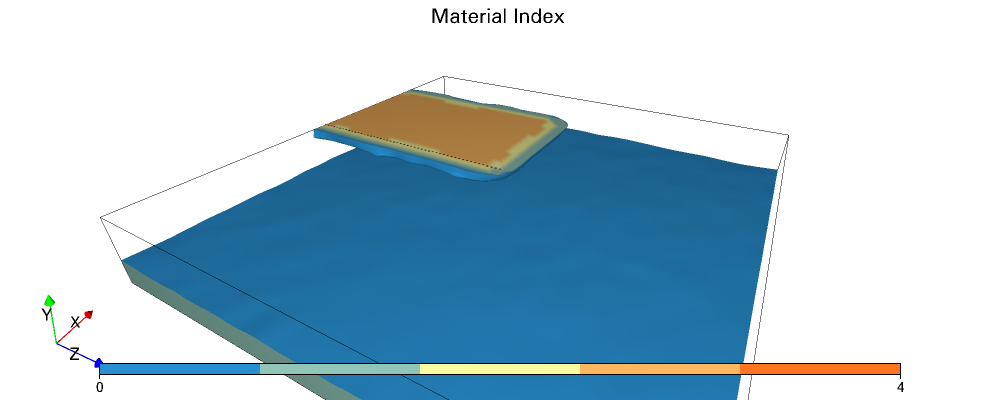

In [13]:
# plot isosurface for materialField values = 0.5
figMaterialLayout = glucifer.Figure( figsize=(1000,400), quality=2, title='Material Index', axis=True )
figMaterialLayout.append(glucifer.objects.IsoSurface( mesh, materialField, isovalues=[0.5], 
                                                     isowalls=True, shift=1, discrete=True))
figMaterialLayout.append(glucifer.objects.Points(trenchSwarm, colourBar=False, pointSize=2 ))
figMaterialLayout.append(glucifer.objects.Points(slab1Swarm,  colourBar=False, pointSize=2 ))
figMaterialLayout.append(glucifer.objects.Points(slab2Swarm,  colourBar=False, pointSize=2 ))
figMaterialLayout.append(glucifer.objects.Points(slab3Swarm,  colourBar=False, pointSize=2 ))

camera = ['rotate y 60', 'rotate x 30']
figMaterialLayout.script(camera)
figMaterialLayout.show()

Set up material parameters and functions
----

In [14]:
upperMantleViscosity =    1.0
lowerMantleViscosity =  100.0
upperViscosity       = 1000.0
core1Viscosity       =  300.0
core2Viscosity       =   50.0
lowerViscosity       =  200.0

# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))
cohesion = 0.06
vonMises = 0.5 * cohesion / (strainRate_2ndInvariant+1.0e-18)

# The upper slab viscosity is the minimum of the 'slabViscosity' or the 'vonMises' 
slabYieldvisc = fn.exception.SafeMaths( fn.misc.min(vonMises, upperViscosity) )

# Viscosity function for the materials 
viscosityMap = { upperMantleIndex : upperMantleViscosity, 
                 lowerMantleIndex : lowerMantleViscosity, 
                 upperSlabIndex   : slabYieldvisc, 
                 core1SlabIndex   : core1Viscosity,
                 core2SlabIndex   : core2Viscosity,
                 lowerSlabIndex   : slabYieldvisc,
               }
viscosityFn = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

In [15]:
viscosityField = uw.mesh.MeshVariable( mesh, 1 )
viscosityProjector = uw.utils.MeshVariable_Projection( viscosityField, viscosityFn, type=0 )
viscosityProjector.solve()


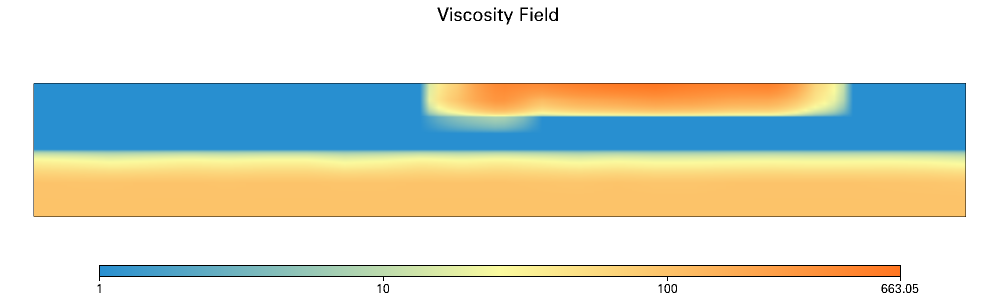

In [16]:
viscosity = glucifer.objects.Surface( mesh, viscosityField, crossSection="z 0%", logScale=True, axis=True  )
viscosity.colourBar["tickvalues"] = [1, 10, 100, 1000]

figViscosity = glucifer.Figure( figsize=(1000,300), quality=2, title='Viscosity Field' )
figViscosity.append(viscosity)
figViscosity.show()

Set the density function, vertical unit vector and Buoyancy Force function


In [17]:
mantleDensity = 0.0
slabDensity   = 1.0 

densityMap = { upperMantleIndex : mantleDensity, 
               lowerMantleIndex : mantleDensity, 
               upperSlabIndex   : slabDensity, 
               core1SlabIndex   : slabDensity,
               core2SlabIndex   : slabDensity,
               lowerSlabIndex   : slabDensity, 
             }
densityFn = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat = ( 0., 1., 0. )

# now create a buoyancy force vector
buoyancyFn = -1.0 * densityFn * z_hat

**Set boundary conditions**

In [18]:
# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls, kWalls) )

**System Setup**

In [19]:
# Initial linear slab viscosity setup
stokes = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = viscosityFn, 
                               fn_bodyforce   = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)
solver.options.scr.ksp_rtol = 1.0e-3

In [20]:
# use "lu" direct solve if running in serial
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

In [21]:
advectorSwarm  = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advectorTrench = uw.systems.SwarmAdvector( swarm=trenchSwarm, velocityField=velocityField, order=2 )
advectorSlab1  = uw.systems.SwarmAdvector( swarm=slab1Swarm, velocityField=velocityField, order=2 )
advectorSlab2  = uw.systems.SwarmAdvector( swarm=slab2Swarm, velocityField=velocityField, order=2 )
advectorSlab3  = uw.systems.SwarmAdvector( swarm=slab3Swarm, velocityField=velocityField, order=2 )

**Analysis tools**

In [22]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

Parameter 'resolutionI' is deprecated, please use resolution=[I,J,K]
Parameter 'resolutionJ' is deprecated, please use resolution=[I,J,K]
Parameter 'resolutionK' is deprecated, please use resolution=[I,J,K]



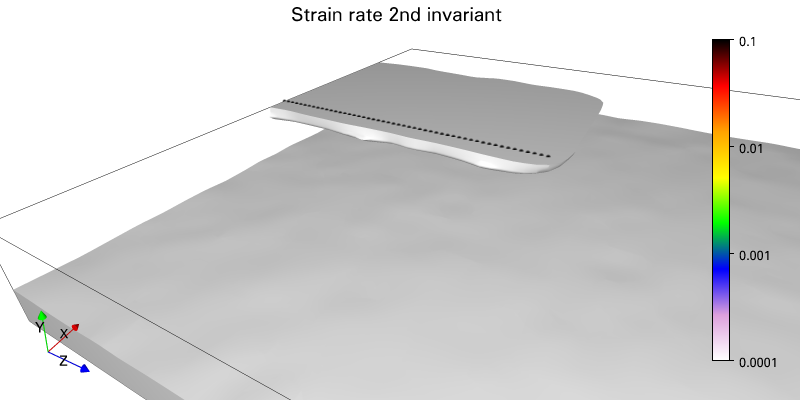

In [23]:
# set up visualisation of slab isosurface with strain rate.
figMaterialStrain = glucifer.Figure( figsize=(800,400), title="Strain rate 2nd invariant", 
                                    facecolour='white', quality=3, axis=True )

# plot isosurface with strain rate for material index > 0.5
surf = figMaterialStrain.IsoSurface( mesh, materialField, strainRate_2ndInvariant, logScale=True,
                                     isovalues=[0.5], isowalls=True, valueRange=[0.0001, 0.1], 
                                     colours='White Plum Blue Green Yellow Orange Red Black')
surf.colourBar["position"] = 0.0
surf.colourBar["size"] = [0.8,0.02]
surf.colourBar["tickvalues"] = [0.0001, 0.001, 0.01, 0.1]
surf.colourBar["align"] = "right"
figMaterialStrain.append(surf)

#Cross sections at the boundaries, use the same colour map as isosurface
figMaterialStrain.append(glucifer.objects.Surface( mesh, strainRate_2ndInvariant, crossSection="x 100%", 
                          colourMap=surf.colourMap, colourBar=False, valueRange=[0.0001, 0.1]))
figMaterialStrain.append(glucifer.objects.Surface( mesh, strainRate_2ndInvariant, crossSection="z 0%",   
                          colourMap=surf.colourMap, colourBar=False, valueRange=[0.0001, 0.1]))

# plot trench tracer particles
figMaterialStrain.append(glucifer.objects.Points(trenchSwarm, colourBar=False, pointSize=3 ))

# plot velocity vectors
figMaterialStrain.append(glucifer.objects.VectorArrows(mesh, velocityField*1e3, 
                                                       resolutionI=16, resolutionJ=2, resolutionK=16  ))

# change perspecitve
camera = ['rotate y 60', 'rotate x 30', 'zoom 3.0', 'translate x 1.5']
sc = figMaterialStrain.script(camera)

figMaterialStrain.show()

** Checkpointing function**

In [24]:
def checkpoint():
    # save swarms
    swarmHnd       = swarm.save(       outputPath+'swarm.'      + str(step).zfill(5) +'.h5')
    trenchSwarmHnd = trenchSwarm.save( outputPath+'trenchSwarm.'+ str(step).zfill(5) +'.h5')
    slab1SwarmHnd  = slab1Swarm.save(  outputPath+'slab1Swarm.' + str(step).zfill(5) +'.h5')
    slab2SwarmHnd  = slab2Swarm.save(  outputPath+'slab2Swarm.' + str(step).zfill(5) +'.h5')
    slab3SwarmHnd  = slab3Swarm.save(  outputPath+'slab3Swarm.' + str(step).zfill(5) +'.h5')

    # save swarm variables
    materialIndexHnd = materialIndex.save(  outputPath +'materialIndex.'  + str(step).zfill(5) +'.h5')
    
    # save mesh
    meshHnd = mesh.save(outputPath+'mesh.'+ str(step).zfill(5) +'.h5')
    
    # save mesh variable
    velocityHnd = velocityField.save(outputPath+'velocityField.'+ str(step).zfill(5) +'.h5', meshHnd)
    pressureHnd = pressureField.save(outputPath+'pressureField.'+ str(step).zfill(5) +'.h5', meshHnd)

    # and the xdmf files
    velocityField.xdmf(outputPath+'velocityField.'+str(step).zfill(5)+'.xdmf',
                       velocityHnd,     "velocity",      meshHnd, "mesh",modeltime=time)
    pressureField.xdmf(outputPath+'pressureField.'+str(step).zfill(5)+'.xdmf',
                       pressureHnd,     "pressure",      meshHnd, "mesh",modeltime=time)
    materialIndex.xdmf(outputPath+'materialIndex.'+str(step).zfill(5)+'.xdmf',
                       materialIndexHnd,"materialIndex",swarmHnd,"swarm",modeltime=time)


In [25]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advectorSwarm.get_max_dt()
    # Advect using this timestep size.
    advectorSwarm.integrate(dt)
    advectorTrench.integrate(dt)
    advectorSlab1.integrate(dt)
    advectorSlab2.integrate(dt)
    advectorSlab3.integrate(dt)
    
    return time+dt, step+1

Main simulation loop
=======

In [26]:
time = 0. 
step = 0  

In [27]:
maxSteps     = 2   # 300 timesteps at high resolution required to reproduce fig S3c.
steps_output = 2 

In [28]:
while step <= maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
        checkpoint()        

    if(uw.nProcs()==1):
        print 'step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,Vrms)


    time,step = update()

step =      0; time = 0.000e+00; Vrms = 8.877e-06
step =      1; time = 9.847e+02; Vrms = 9.502e-06
step =      2; time = 1.711e+03; Vrms = 9.854e-06



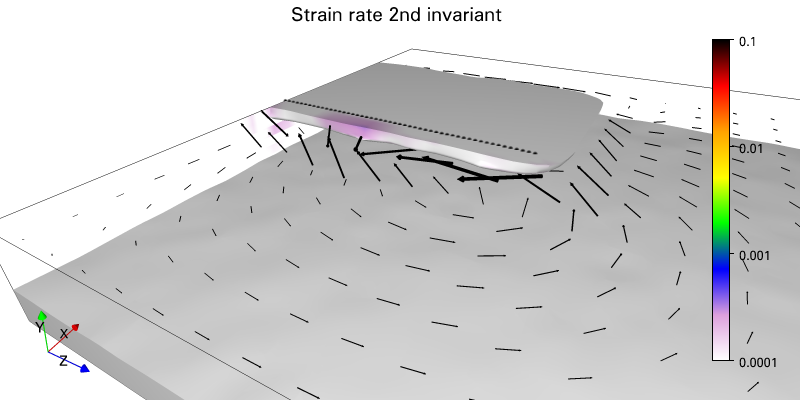

In [29]:
figMaterialStrain.show()